In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import paramiko
import io

In [2]:
def setup_ec2():
    print("Connecting to EC2")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect('3.69.255.112', username='ec2-user', key_filename='airflow-test-key.pem')
    print("Connection successful")
    return ssh

In [3]:
def get_data_ec2(ssh, remote_path):
    print("Reading CSV files from " + remote_path)
    stdin, stdout, stderr = ssh.exec_command('ls ' + remote_path + '/*.csv')
    file_list = [filename.strip() for filename in stdout.readlines()]
    # Loop over list of file names and read each CSV file into a pandas DataFrame
    df_list = []
    for filename in file_list:
        transport = ssh.get_transport()
        channel = transport.open_channel('session')
        channel.exec_command('cat ' + filename)
        file_obj = io.StringIO()
        for line in channel.makefile('r'):
            file_obj.write(line)
        file_obj.seek(0)
        df = pd.read_csv(file_obj)
        df_list.append(df)
        channel.close()
    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(df_list, ignore_index=True)
    return df

In [33]:
ssh = setup_ec2()
remote_path = '/home/ec2-user/ecomm/ecomm_comp/ecomm_comp/products/garmin_smartwatch_2023_03_12_17_13_22_clustered'
df = get_data_ec2(ssh, remote_path)
ssh.close()

Connecting to EC2
Connection successful
Reading CSV files from /home/ec2-user/ecomm/ecomm_comp/ecomm_comp/products/garmin_smartwatch_2023_03_12_17_13_22_clustered


In [41]:
df.columns

Index(['price', 'source', 'timestamp', 'link', 'title'], dtype='object')

In [35]:
df.shape

(8524, 5)

In [36]:
df.head()

,price,source,timestamp,link,title
0,215.0,Bol,2023-03-13 16:34:11.001841,https://bol.com/nl/nl/p/garmin-vivoactive-4s-s...,Garmin Vivoactive 4S Smartwatch - Sporthorloge...
1,198.0,Amazon,2023-03-13 16:34:11.001841,https://www.amazon.nl/V%C3%ADvoactive-Training...,Garmin vívoactive 4 — waterdichte GPS-smartwat...
2,199.0,Bol,2023-03-14 19:00:14.476672,https://bol.com/nl/nl/p/garmin-vivoactive-4s-s...,Garmin Vivoactive 4S Smartwatch - Sporthorloge...
3,198.0,Amazon,2023-03-14 19:00:14.476672,https://www.amazon.nl/V%C3%ADvoactive-Training...,Garmin vívoactive 4 — waterdichte GPS-smartwat...
4,199.0,Bol,2023-03-14 20:00:13.901101,https://bol.com/nl/nl/p/garmin-vivoactive-4s-s...,Garmin Vivoactive 4S Smartwatch - Sporthorloge...


In [37]:
original_df = df

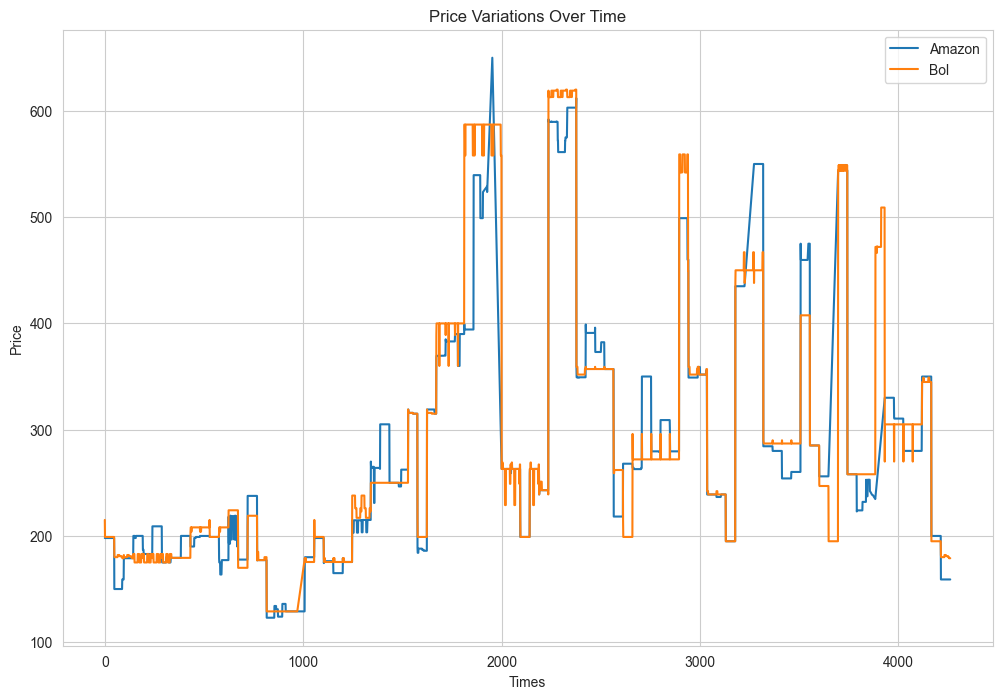

In [53]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))

amazon_data = df[df['source'] == 'Amazon']
bol_data = df[df['source'] == 'Bol']

amazon_list = amazon_data["price"].to_list()
bol_list = bol_data["price"].to_list()

# Create a line plot
sns.lineplot(amazon_list, label='Amazon')
sns.lineplot(bol_list, label='Bol')

# Add plot labels and titles
plt.xlabel('Times')
plt.ylabel('Price')
plt.title('Price Variations Over Time')

# Show the plot
plt.show()